In [82]:
from astropy.io import fits as pyfits
import numpy as np
import matplotlib.pyplot as pl
import glob
import os
from scipy.ndimage.measurements import label
%matplotlib inline

In [114]:
def getFlux(plot=True):
    """Return a (random) stitching of the postage stamps for C9."""
    ntime = 1290
    nrows = 100
    ncols = 100
    ntries = 100
    flux = np.zeros((ntime, nrows, ncols)) * np.nan
    files = glob.glob('data/c9/*/*/*.fits.gz')

    for file in files:
        with pyfits.open(file) as f:
            ftmp = f[1].data['FLUX']
            for i in range(ntries):
                row = np.random.randint(0, nrows - ftmp.shape[1])
                col = np.random.randint(0, ncols - ftmp.shape[2])
                if np.all(np.isnan(flux[0, row:row + ftmp.shape[1], col:col + ftmp.shape[2]])):
                    flux[:, row:row + ftmp.shape[1], col:col + ftmp.shape[2]] = ftmp
                    break
            if i == ntries - 1:
                raise Exception("Unable to place image.")
    if plot:
        fig = pl.figure(figsize=(14, 14))
        pl.imshow(flux[0], vmax=1e4);
    return flux

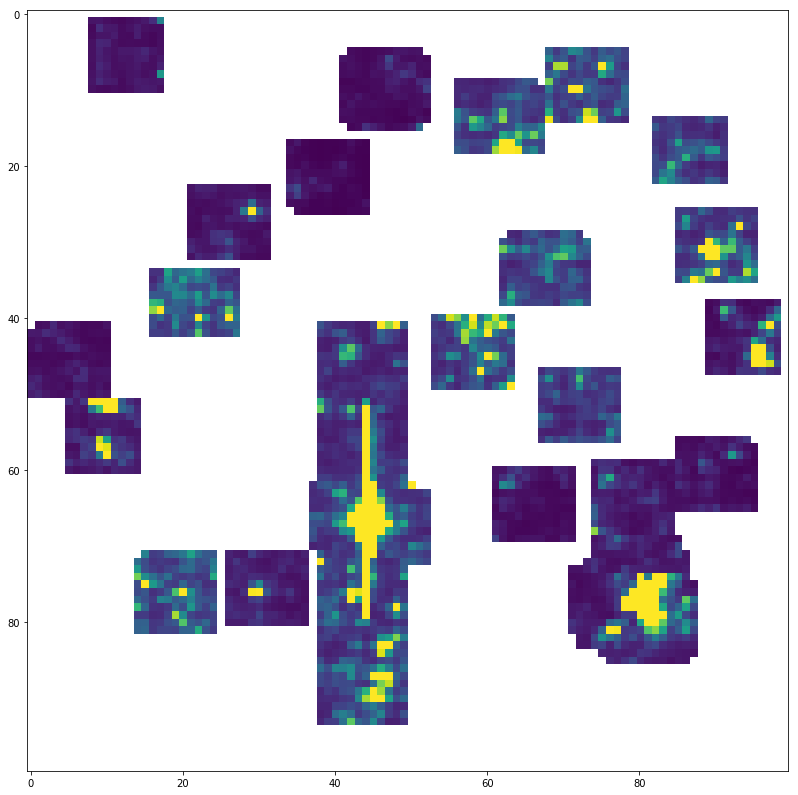

In [115]:
# Get the flux
flux = getFlux(True)

/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:907: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


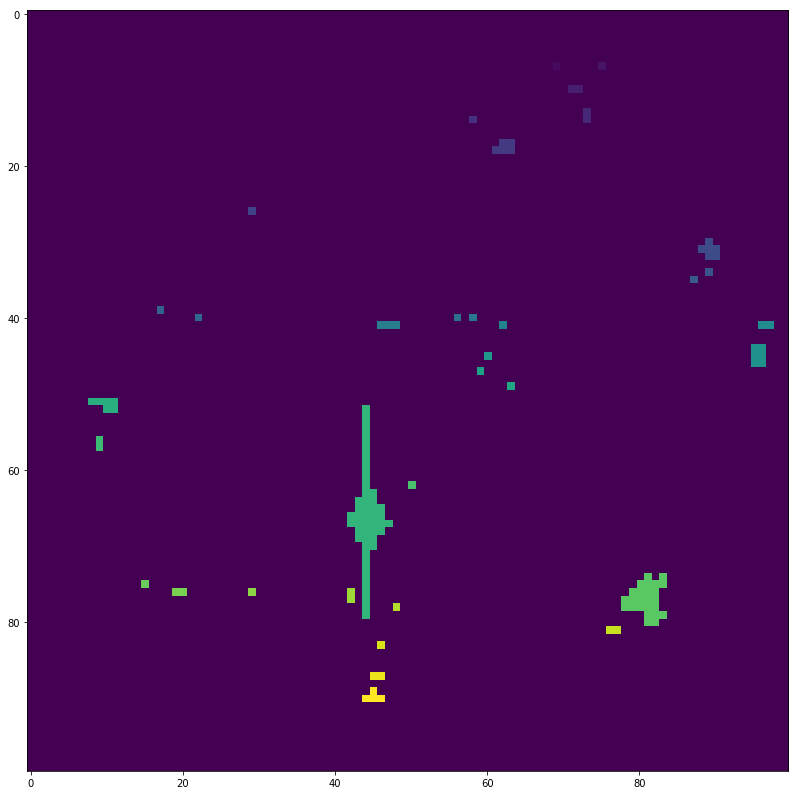

In [133]:
img = np.nanmedian(flux, axis=0)
mu = np.nanmedian(img)
sigma = np.sqrt(np.nanmedian((img-mu)**2))
m = (img - mu) > 10*sigma
m &= np.isfinite(img)
labels, nstar = label(m)
fig = pl.figure(figsize=(14, 14))
pl.imshow(labels);